In [ ]:
!pip install kmodes

In [1]:
# importing random module
import random
import numpy as np

random.seed(3)
np.random.seed(3)

NameError: ignored

In [2]:
import pandas as pd


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Preprocessing Groceries Dataset

In [4]:
data = pd.read_csv('Groceries_dataset.csv')

In [5]:
groceries_df = pd.DataFrame(data)

# Group the data by 'Member_number' and collect 'itemDescription' as items in transactions
groceries_transactions = groceries_df.groupby(['Member_number','Date'])['itemDescription'].apply(list).reset_index()

# Convert the lists in the "itemDescription" column to sets
groceries_transactions["itemDescription"] = groceries_transactions["itemDescription"].apply(set)
print(groceries_transactions.head())
# Convert the transactions into a list of lists
transactions_list = groceries_transactions['itemDescription'].tolist()


   Member_number        Date  \
0           1000  15-03-2015   
1           1000  24-06-2014   
2           1000  24-07-2015   
3           1000  25-11-2015   
4           1000  27-05-2015   

                                     itemDescription  
0  {yogurt, sausage, whole milk, semi-finished br...  
1                  {pastry, whole milk, salty snack}  
2                     {misc. beverages, canned beer}  
3                        {sausage, hygiene articles}  
4                         {soda, pickled vegetables}  


In [6]:
groceries_df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [7]:
len(transactions_list)

14963

In [8]:
groc_df = pd.DataFrame(groceries_transactions)

In [9]:
# groc_df = groc_df.drop(['Member_number'],axis=1)
groc_df.head()

,Member_number,Date,itemDescription
0,1000,15-03-2015,"{yogurt, sausage, whole milk, semi-finished br..."
1,1000,24-06-2014,"{pastry, whole milk, salty snack}"
2,1000,24-07-2015,"{misc. beverages, canned beer}"
3,1000,25-11-2015,"{sausage, hygiene articles}"
4,1000,27-05-2015,"{soda, pickled vegetables}"


In [10]:
len(groceries_df)

38765

In [11]:

# Convert sets to a single string with items separated by a comma
groceries_transactions["itemDescription"] = groceries_transactions["itemDescription"].agg(lambda x: ",".join(x))

groceries_transactions = groceries_transactions["itemDescription"].str.split(',')

print(groceries_transactions.head())

0    [yogurt, sausage, whole milk, semi-finished br...
1                    [pastry, whole milk, salty snack]
2                       [misc. beverages, canned beer]
3                          [sausage, hygiene articles]
4                           [soda, pickled vegetables]
Name: itemDescription, dtype: object


Apriori

In [19]:
def prune(data,supp):
    df = data[data.supp_count >= supp]
    return df

def count_itemset(transaction_df, itemsets):
    count_item = {}
    for item_set in itemsets:
        set_A = set(item_set)
        for row in transaction_df:
            set_B = set(row)

            if set_B.intersection(set_A) == set_A:
                if item_set in count_item.keys():
                    count_item[item_set] += 1

                else:
                    count_item[item_set] = 1

    data = pd.DataFrame()
    data['item_sets'] = count_item.keys()
    data['supp_count'] = count_item.values()
    print("Candidate itemset table (Counting):\n", data)

    return data

def count_item(trans_items):
    count_ind_item = {}
    for row in trans_items:
        for i in range(len(row)):
            if row[i] in count_ind_item.keys():
                count_ind_item[row[i]] += 1
            else:
                count_ind_item[row[i]] = 1

    data = pd.DataFrame()
    data['item_sets'] = count_ind_item.keys()
    data['supp_count'] = count_ind_item.values()
    data = data.sort_values('item_sets')

    return data

def join(list_of_items):
    itemsets = []
    i = 1
    for entry in list_of_items:
        proceding_items = list_of_items[i:]
        for item in proceding_items:
            if(type(item) is str):
                if entry != item:
                    tuples = (entry, item)
                    itemsets.append(tuples)
            else:
                if entry[0:-1] == item[0:-1]:
                    tuples = entry+item[1:]
                    itemsets.append(tuples)
        i = i+1
    if(len(itemsets) == 0):
        return None

    return itemsets

def apriori2(trans_data,supp=10):
    freq = pd.DataFrame()

    df = count_item(trans_data)

    while(len(df) != 0):

        df = prune(df, supp)
        print("Minsup =", supp,"\n")
        print("Freq itemset table (Pruned):\n", df)

        if len(df) > 1 or (len(df) == 1 and int(df.supp_count >= supp)):
            freq = df

        itemsets = join(df.item_sets)

        if(itemsets is None):
            return freq

        df = count_itemset(trans_data, itemsets)
    return freq

In [20]:
groceries_transactions.head()

0    [yogurt, sausage, whole milk, semi-finished br...
1                    [pastry, whole milk, salty snack]
2                       [misc. beverages, canned beer]
3                          [sausage, hygiene articles]
4                           [soda, pickled vegetables]
Name: itemDescription, dtype: object

# Apriori on Groceries Dataset

In [33]:
frequent_itemsets = apriori2(groceries_transactions,1000)

Minsup = 1000 

Freq itemset table (Pruned):
            item_sets  supp_count
18  other vegetables        1827
13        rolls/buns        1646
24   root vegetables        1041
9               soda        1453
21    tropical fruit        1014
2         whole milk        2363
0             yogurt        1285
Candidate itemset table (Counting):
                               item_sets  supp_count
0        (other vegetables, rolls/buns)         158
1   (other vegetables, root vegetables)          79
2              (other vegetables, soda)         145
3    (other vegetables, tropical fruit)          94
4        (other vegetables, whole milk)         222
5            (other vegetables, yogurt)         121
6         (rolls/buns, root vegetables)          86
7                    (rolls/buns, soda)         121
8          (rolls/buns, tropical fruit)          91
9              (rolls/buns, whole milk)         209
10                 (rolls/buns, yogurt)         117
11              (root vegetab

In [34]:
print(len(frequent_itemsets))

7


In [35]:
from itertools import combinations

# Convert the frequent itemsets into features for clustering

In [36]:
def convert_to_transdf(data):
    # Create a set of all unique items
    all_items = set()
    for entry in data:
      all_items.update(entry["items"])

    # Generate all possible combinations of items
    combinations_list = []
    for r in range(1, len(all_items) + 1):
      item_combinations = combinations(all_items, r)
      combinations_list.extend(item_combinations)

    # Create a DataFrame with features for each combination
    df = pd.DataFrame(data)
    for combination in combinations_list:
      feature_name = " & ".join(sorted(list(combination)))
      df[feature_name] = df["items"].apply(lambda x: int(set(combination).issubset(x)))

    # Fill NaN values with 0
    df.fillna(0, inplace=True)

    # Set the "record_id" as the DataFrame index
    df.set_index("record_id", inplace=True)

    # Print the resulting DataFrame
    print(df)

    return df



In [37]:
# frequent_itemsets = frequent_itemsets.reset_index()

In [38]:
print(dict(frequent_itemsets['item_sets']))

{18: 'other vegetables', 13: 'rolls/buns', 24: 'root vegetables', 9: 'soda', 21: 'tropical fruit', 2: 'whole milk', 0: 'yogurt'}


In [39]:
input_data=dict(frequent_itemsets['item_sets'])

transformed_data = []
record_id = 1

for _, items_tuple in input_data.items():
    # items_set = set(items_tuple)
    transformed_data.append({"record_id": record_id, "items": items_tuple})
    record_id += 1

print(transformed_data)

[{'record_id': 1, 'items': 'other vegetables'}, {'record_id': 2, 'items': 'rolls/buns'}, {'record_id': 3, 'items': 'root vegetables'}, {'record_id': 4, 'items': 'soda'}, {'record_id': 5, 'items': 'tropical fruit'}, {'record_id': 6, 'items': 'whole milk'}, {'record_id': 7, 'items': 'yogurt'}]


In [ ]:
trans_data = convert_to_transdf(transformed_data)

Streaming output truncated to the last 5000 lines.
<ipython-input-36-4945e090ff1a>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df["items"].apply(lambda x: int(set(combination).issubset(x)))
<ipython-input-36-4945e090ff1a>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df["items"].apply(lambda x: int(set(combination).issubset(x)))
<ipython-input-36-4945e090ff1a>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

In [ ]:
# Set 'items' as the index
trans_data.set_index('items', inplace=True)

# Transpose the DataFrame
transposed_data = trans_data.T

# # # Reset the index for a clean DataFrame
transposed_data.reset_index(drop=True, inplace=True)

# Make sure the column names are the unique values from the 'items' column
# Convert sets to strings for column names
transposed_data.columns = transposed_data.columns.map(lambda x: ', '.join(sorted(list(x))))

# Display the resulting DataFrame
print(transposed_data.head())

In [ ]:
trans_data_features = transposed_data
trans_data_features.shape

#  KModes

In [ ]:
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
from sklearn import metrics
from tqdm import tqdm

# Create an array to store the inertia (within-cluster sum of squares) values for different cluster numbers
inertia_values = []

# Define a range of cluster numbers to try
cluster_range = range(1, 7)

# Iterate through each cluster number and fit KModes
for num_clusters in tqdm(cluster_range, desc="Fitting KModes"):
    km = KModes(n_clusters=num_clusters, init="Huang", n_init=1, verbose=0)
    km.fit_predict(trans_data_features)

    # Append the inertia value to the array
    inertia_values.append(km.cost_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


From the elbow plot, optimal number of clusters = 3

In [ ]:
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score

# Find optimal k using silhouette score
silhouette_scores = []
cluster_range = range(2, 6)

for num_clusters in cluster_range:
    km = KModes(n_clusters=num_clusters, init="Huang", n_init=1, verbose=0)
    labels = km.fit_predict(trans_data_features)
    silhouette_scores.append(silhouette_score(trans_data_features, labels))

optimal_k = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print("Optimal number of clusters (k):", optimal_k)


From the silhouette_score, optimal number of clusters = 3

In [ ]:
optimal_num_clusters = 3

In [ ]:
km_2 = KModes(n_clusters=optimal_num_clusters, init="Huang")
result = km_2.fit_predict(trans_data_features)
cluster_centroids = km_2.cluster_centroids_

In [ ]:
trans_data_features['Cluster_Labels'] = result
print(trans_data_features['Cluster_Labels'])

record_id
1     2
2     2
3     2
4     0
5     1
6     1
7     1
8     0
9     0
10    0
11    2
12    2
13    2
14    2
15    2
Name: Cluster_Labels, dtype: uint16


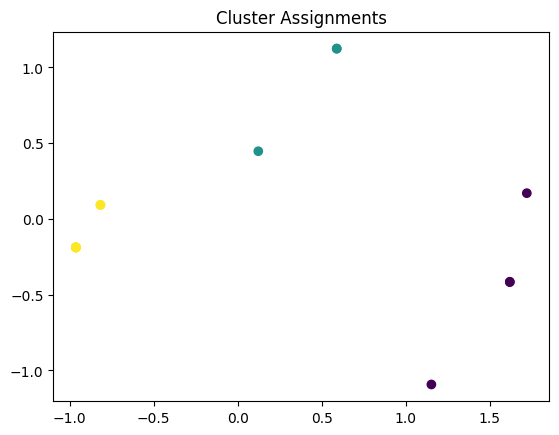

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality for visualization (adjust n_components as needed)
pca = PCA(n_components=2)
trans_data_pca = pca.fit_transform(trans_data_features)

# Plot clusters in 2D
plt.scatter(trans_data_pca[:, 0], trans_data_pca[:, 1], c=result, cmap='viridis')
plt.title('Cluster Assignments')
plt.show()

In [ ]:
trans_data_features = trans_data_features.drop('Cluster_Labels',axis=1)

In [ ]:
from kmodes.kmodes import KModes
import pandas as pd

# Assuming trans_data_features is a DataFrame
km_2 = KModes(n_clusters=optimal_num_clusters, init="Huang", verbose=0)
result = km_2.fit_predict(trans_data_features)

# Access the cluster centroids
cluster_centroids = km_2.cluster_centroids_

# Create a DataFrame for visualization
feature_importance = pd.DataFrame(cluster_centroids, columns=trans_data_features.columns)

# Display the most common category for each feature in each cluster
for cluster_num in range(optimal_num_clusters):
    print(f"\nCluster {cluster_num + 1}:")
    for feature in trans_data_features.columns:
        most_common_category = feature_importance.loc[cluster_num, feature]
        print(f"{feature}: {most_common_category}")

# If you want to see the entire DataFrame
print("\nCluster Centroids:")
print(feature_importance.head())

Streaming output truncated to the last 5000 lines.
bottled beer & citrus fruit & rolls/buns & root vegetables & soda & yogurt: 0
other vegetables & rolls/buns & root vegetables & soda & tropical fruit & yogurt: 0
bottled beer & other vegetables & rolls/buns & soda & tropical fruit & yogurt: 0
bottled beer & rolls/buns & root vegetables & soda & tropical fruit & yogurt: 0
bottled beer & other vegetables & rolls/buns & root vegetables & soda & yogurt: 0
citrus fruit & other vegetables & root vegetables & soda & tropical fruit & yogurt: 0
bottled beer & citrus fruit & other vegetables & soda & tropical fruit & yogurt: 0
bottled beer & citrus fruit & root vegetables & soda & tropical fruit & yogurt: 0
bottled beer & citrus fruit & other vegetables & root vegetables & soda & yogurt: 0
bottled beer & other vegetables & root vegetables & soda & tropical fruit & yogurt: 0
bottled water & citrus fruit & rolls/buns & sausage & soda & tropical fruit: 0
bottled water & citrus fruit & other vegetab

In [ ]:
# Assuming labels is a Series with the true labels for each data point
cluster_labels = pd.DataFrame({'Cluster': result, 'Label': labels})
cluster_labels.groupby('Cluster')['Label'].value_counts()

Cluster  Label
0        4        2
         0        1
1        0        5
         1        1
         2        1
         3        1
2        0        3
         4        1
Name: Label, dtype: int64

In [ ]:
from kmodes.kmodes import KModes
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds for each cluster
cluster_texts = []

# Assuming 'result' contains the cluster assignments
for cluster_label in range(optimal_num_clusters):
    # Select rows in the cluster
    cluster_data = trans_data_features[result == cluster_label]

    # Get the list of column names with value 1
    cluster_transactions = cluster_data.columns[cluster_data.iloc[0] == 1].tolist()

    # Append the list of transactions to cluster_texts
    cluster_texts.append(cluster_transactions)

# Check and display word clouds only for non-empty clusters
for i, cluster_text in enumerate(cluster_texts):
    if cluster_text:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cluster_text))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Cluster {i + 1} Word Cloud')
        plt.show()
    else:
        print(f'Cluster {i + 1} is empty.')

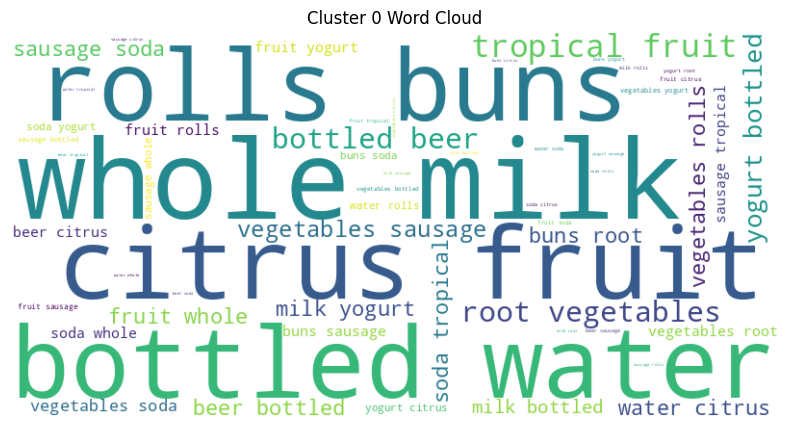

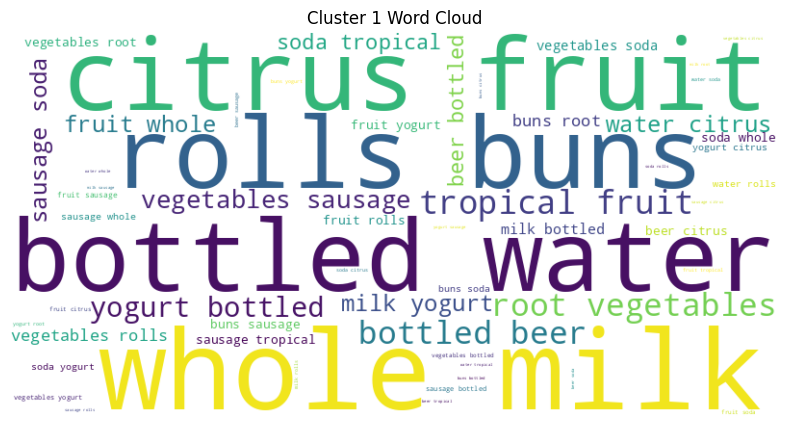

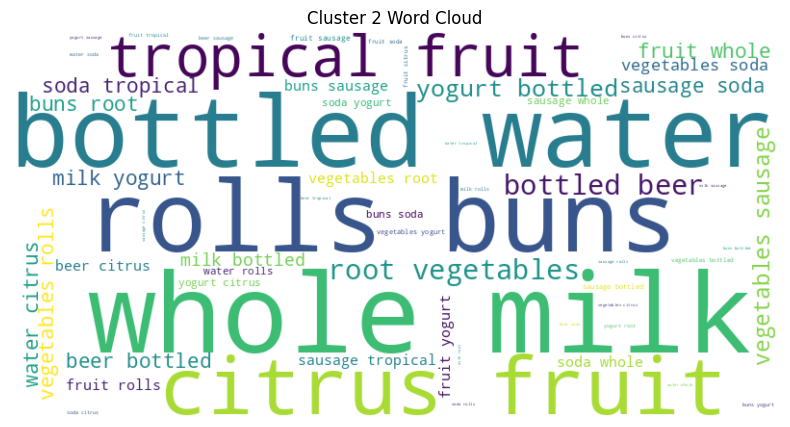

In [ ]:
from kmodes.kmodes import KModes
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds for each cluster
cluster_texts = []

# Assuming 'result' contains the cluster assignments
for cluster_label in range(optimal_num_clusters):
    # Select rows in the cluster
    cluster_data = trans_data_features[result == cluster_label]

    # Get the list of column names with value 1
    cluster_transactions = cluster_data.columns[cluster_data.iloc[0] == 1].tolist()

    # Append the list of transactions to cluster_texts
    cluster_texts.append(cluster_transactions)

# Check and display word clouds only for non-empty clusters
for i, cluster_text in enumerate(cluster_texts):
    if cluster_text:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cluster_text))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Cluster {i + 1} Word Cloud')
        plt.show()
    else:
        print(f'Cluster {i + 1} is empty.')

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from sklearn.decomposition import PCA
from kmodes.kmodes import KModes

# Convert cluster centroids to DataFrame
centroid_df = pd.DataFrame(cluster_centroids, columns=trans_data_features.columns)

# Apply PCA for dimensionality reduction (adjust n_components as needed)
pca = PCA(n_components=3)
trans_data_pca = pca.fit_transform(trans_data_features)

# Add cluster labels to the PCA-transformed data
trans_data_pca_df = pd.DataFrame(trans_data_pca, columns=['PCA1', 'PCA2', 'PCA3'])
trans_data_pca_df['Cluster'] = result

# Create an interactive 3D scatter plot
fig = px.scatter_3d(
    trans_data_pca_df,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='Cluster',
    title='3D Scatter Plot of Clusters',
    labels={'PCA1': 'Principal Component 1', 'PCA2': 'Principal Component 2', 'PCA3': 'Principal Component 3'}
)

# Add cluster centroids to the plot
fig.add_trace(go.Scatter3d(x=cluster_centroids[:,0], y=cluster_centroids[:,1], z=cluster_centroids[:,2],  text="Centroid", mode='markers', marker=dict(size=10, color='black')))

# Show the plot
fig.show()


In [ ]:
from sklearn import metrics
from gap_statistic import OptimalK

# Evaluate the clustering

# 1. Silhouette Score
silhouette_avg = metrics.silhouette_score(trans_data_features, result, metric='hamming')
print(f"Silhouette Score: {silhouette_avg}")

# 2. Davies-Bouldin Index
davies_bouldin = metrics.davies_bouldin_score(trans_data_features, result)
print(f"Davies-Bouldin Index: {davies_bouldin}")



# DBSCAN

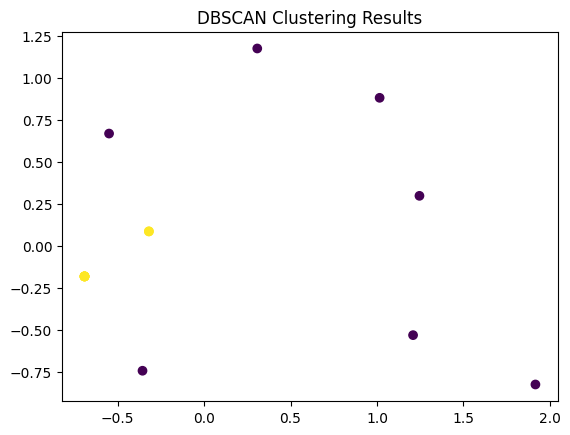

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming trans_data_features is your DataFrame
pca = PCA(n_components=2)
trans_data_features_pca = pca.fit_transform(trans_data_features)

dbscan = DBSCAN(eps=0.5, min_samples=7)
dbscan_labels = dbscan.fit_predict(trans_data_features_pca)

# Visualize the clusters in 2D
plt.scatter(trans_data_features_pca[:, 0], trans_data_features_pca[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clustering Results')
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
import plotly.express as px
# Evaluate clustering performance
silhouette = silhouette_score(trans_data_features, dbscan_labels, metric="hamming")
davies_bouldin = davies_bouldin_score(trans_data_features, dbscan_labels)

print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")


Silhouette Score: 0.9951526005053006
Davies-Bouldin Index: 1.21460212147628


In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
from kmodes.kmodes import KModes

# Assuming 'trans_data_features' is your feature matrix and 'optimal_num_clusters' is the optimal number of clusters determined previously

# Apply PCA for dimensionality reduction (adjust n_components as needed)
pca = PCA(n_components=3)
trans_data_pca = pca.fit_transform(trans_data_features)

# Add cluster labels to the PCA-transformed data
trans_data_pca_df = pd.DataFrame(trans_data_pca, columns=['PCA1', 'PCA2', 'PCA3'])
trans_data_pca_df['Cluster'] = result

# Create an interactive 3D scatter plot
fig = px.scatter_3d(
    trans_data_pca_df,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='Cluster',
    title='3D Scatter Plot of Clusters',
    labels={'PCA1': 'Principal Component 1', 'PCA2': 'Principal Component 2', 'PCA3': 'Principal Component 3'}
)

# Show the plot
fig.show()


In [ ]:
# Assuming labels is a Series with the true labels for each data point
cluster_labels = pd.DataFrame({'Cluster': dbscan_labels, 'Label': labels})
cluster_labels.groupby('Cluster')['Label'].value_counts()

Cluster  Label
-1       7           7
         6           1
 0       0           8
         4           7
 1       3          14
 2       8           7
 3       1           8
         2           8
 4       0        8124
 5       5           7
Name: Label, dtype: int64

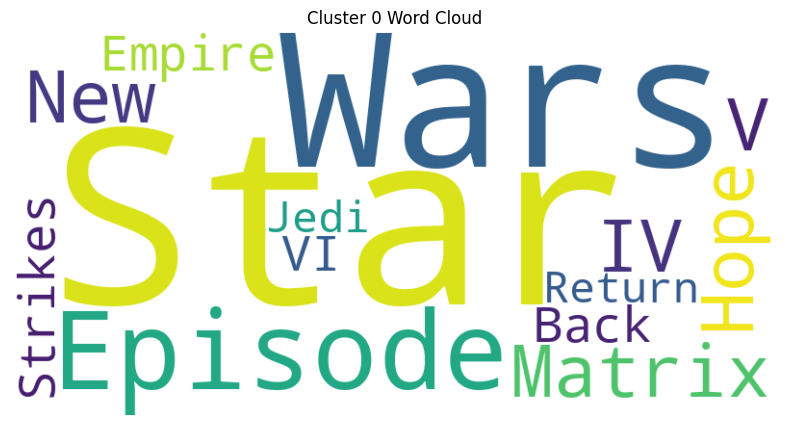

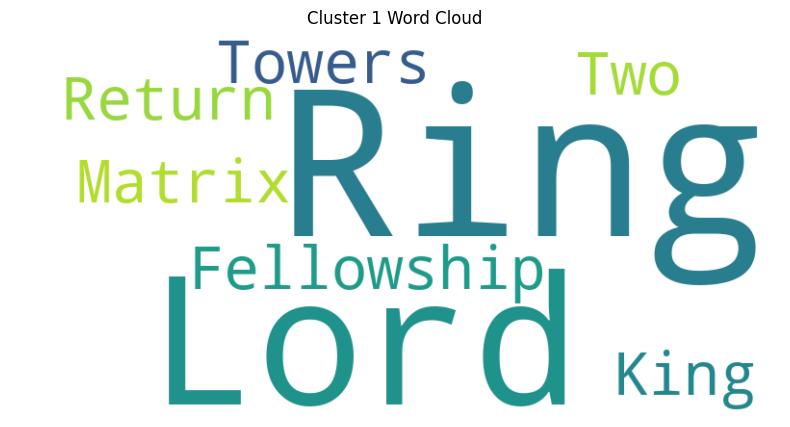

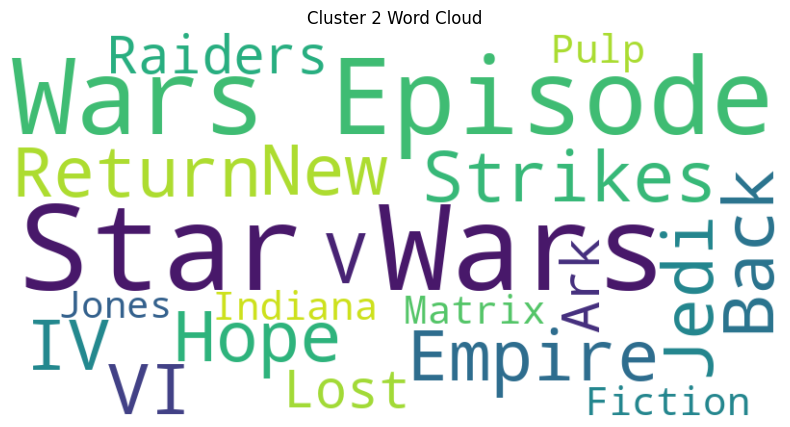

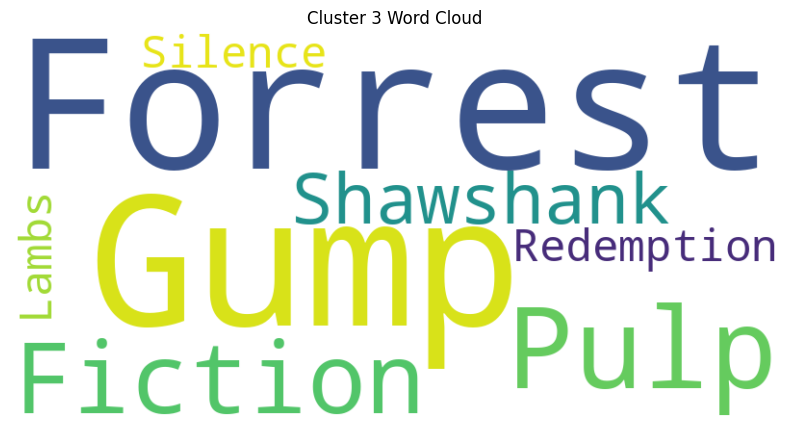

Cluster 4 is empty.


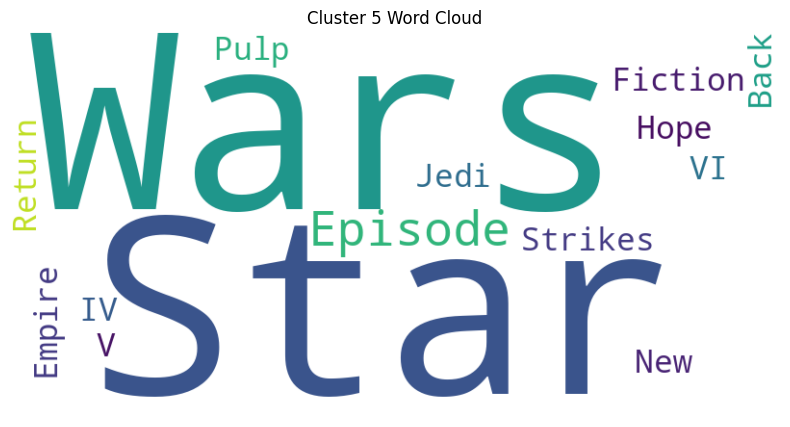

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'dbscan_labels' contains the cluster assignments
cluster_texts = []

# Select rows in the cluster
for cluster_label in set(dbscan_labels):
    if cluster_label == -1:  # Noise points
        continue

    cluster_data = trans_data_features[dbscan_labels == cluster_label]

    # Convert each row to a list of movie names
    cluster_transactions = [
        trans_data_features.columns[j] for j in range(cluster_data.shape[1]) if cluster_data.iloc[i, j] == 1
    ]

    # Append the list of transactions to cluster_texts
    cluster_texts.append(cluster_transactions)

# Check and display word clouds only for non-empty clusters
for i, cluster_text in enumerate(cluster_texts):
    if cluster_text:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cluster_text))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Cluster {i} Word Cloud')
        plt.show()
    else:
        print(f'Cluster {i} is empty.')
